In [51]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [52]:
def plot_(x, y):
    plt.plot(x, y)
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [53]:
def dataGen(x, func):
    # generate the train data
    return x, func_(x)

In [54]:
from scipy.integrate import odeint as odeint_scipy

In [55]:
func_ = lambda t, x : x

In [56]:
batch_time = 10
data_size = 1000
batch_size = 20

In [57]:
true_y0 = torch.tensor(0.)
t = torch.linspace(0., 5., data_size)

In [58]:
true_y = odeint_scipy(func_, true_y0, t)

In [59]:
true_y.shape, t.shape, type(true_y), type(t)

((1000, 1), torch.Size([1000]), numpy.ndarray, torch.Tensor)

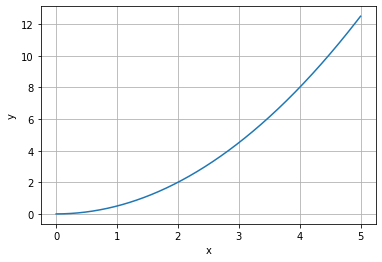

In [60]:
plot_(t, true_y)   # e^x

Train Neural ODE for simple e^x function

In [71]:
from torchdiffeq import odeint

In [72]:
def visualize(true_y, pred_y, odefunc, itr, title):
    
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    plt.show(block=False)
    
    ax.cla()
    ax.set_title(title)
    ax.set_xlabel('t')
    ax.set_ylabel('y')
    ax.plot(t.cpu().numpy(), true_y.cpu().numpy()[:], t.cpu().numpy(), true_y.cpu().numpy()[:], 'g-')
    ax.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:], 'b--')
    ax.set_xlim(t.cpu().min(), t.cpu().max())
    ax.set_ylim(-2, 2)
    ax.legend()

    fig.tight_layout()
    plt.savefig('png/{:03d}'.format(itr))
    plt.draw()
    plt.pause(0.001)

In [73]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [74]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [75]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [83]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
            
    def forward(self, t, y):
        return self.net(y)

In [84]:
batch_time = 10
data_size = 1000
batch_size = 20
niters = 2000
test_freq = 20

In [85]:
ii = 0
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

In [86]:
type(true_y), type(t)

(torch.Tensor, torch.Tensor)

In [87]:
true_y = torch.tensor(true_y).to(device)

/tmp/ipykernel_236401/3576442085.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_y = torch.tensor(true_y).to(device)


In [91]:
end = time.time()

time_meter = RunningAverageMeter(0.97)

loss_meter = RunningAverageMeter(0.97)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    #print(type(batch_y0), type(batch_t), type(batch_y))
    pred_y = odeint(func, batch_y0.reshape((20, -1)), batch_t).to(device)
    #print(pred_y.shape, batch_y.shape)
    loss = torch.mean(torch.abs(pred_y - batch_y.reshape_as(pred_y)))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            #print(true_y0.reshape(-1), t.shape)
            pred_y = odeint(func, true_y0.reshape(-1).to(device), t.to(device))
            loss = torch.mean(torch.abs(pred_y - true_y.reshape_as(pred_y).to(device)))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii, "dy/dx = x, f(0) = 1")
            #plot_(t.cpu().numpy(), pred_y.cpu().numpy())
            ii += 1

    end = time.time()

RuntimeError: expected scalar type Float but found Double

In [97]:
batch_y0.shape, batch_t.shape

(torch.Size([20, 1]), torch.Size([10]))